# Note
This Demo is based on './MNIST_VanillaGAN'. The difference with VanillaGAN can be found in ``class divergence``

https://arxiv.org/abs/1606.00709
f-Divergence GANs

The authors empirically demonstrate that when the generative model is
misspecified and does not contain the true distribution, the divergence
function used for estimation has a strong influence on which model is
learned. To address this issue, they theoretically show that the
generative-adversarial approach is a special case of an existing, more
general variational divergence estimation approach and that any
f-divergence can be used for training generative neural samplers (which
are defined as models that take a random input vector and produce a sample
from a probability distribution defined by the network weights). They
then empirically show the effect of using different training
divergences on a trained model's average log likelihood of sampled data.

They test (forward) Kullback-Leibler, reverse Kullback-Leibler, Pearson
chi-squared, Neyman chi-squared, squared Hellinger, Jensen-Shannon,
and Jeffrey divergences.

# Import Necessary Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image 

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
batch_size = 128
num_epoch = 200
z_dimension = 100 # size of input noise
lr_G = 1e-4
lr_D = 1e-4 # leanring rate of Generator and Discriminator
method = 'total_variation'

# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))
])
    
# MNIST datasets downloading……
mnist = datasets.MNIST(
    root = '../../data/mnist/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = mnist, batch_size = batch_size, shuffle = True
)


In [4]:
def to_gray_img(x):
    out = 0.5*(x+1)
    out = out.clamp(0,1) # force therandom distribution of x into [min, max]
    out = out.view(-1, 1, 28, 28) # view a multi-row Tensor as one row
    return out

# Discriminator Definitions (Vanilla FC Fashion)
Considering that the MNIST images are all of 28 * 28 images, the input size of our fully connection network is 784.

It is a **unconditional** version.

In [5]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__() # 说起来这句是干嘛的？
        self.D = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # propability of the given image being Real
        )
    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla FC Fashion)
Considering that the MNIST images are all of 28 * 28 images, the output size of our fully connection network is 784.

The final `Tanh` activataion function can project output into (-1,1)

It is a **unconditional** version.

In [6]:
class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

# IMPORTANT: F-Divergence
We exclude Neyman and Jeffrey due to poor performance and nontrivial
implementations to yield 'convergence' (see scipy.special.lambertw
for how to implement Jeffrey, and Table 6 of Appendix C of the paper
for how to implement Neyman)

In [7]:
class Divergence:
    """ Compute G and D loss using an f-divergence metric.
    Implementations based on Table 6 (Appendix C) of the arxiv paper.
    """
    def __init__(self, method):
        self.method = method.lower().strip() # strip() 方法用于移除字符串头尾指定的字符（默认为空格或换行符）或字符序列。
        assert self.method in ['total_variation',
                               'forward_kl',
                               'reverse_kl',
                               'pearson',
                               'hellinger',
                               'jensen_shannon'],\
            'Invalid divergence'
    
    def D_loss(self, DX_score, DG_score):
        """ Compute batch loss for discriminator using f-divergence metric """
        if self.method == 'total_variation':
            return -(torch.mean(0.5 * torch.tanh(DX_score)) \
                - torch.mean(0.5 * torch.tanh(DG_score)))
        
        elif self.method == 'forward_kl':
            return -(torch.mean(DX_score) - torch.mean(torch.exp(DG_score - 1)))
        
        elif self.method == 'reverse_kl':
            return -(torch.mean(-torch.exp(DX_score)) - torch.mean(-1 - DG_score))
        
        elif self.method == 'pearson':
            return -(torch.mean(DX_score) - torch.mean(0.25 * DG_score ** 2 + DG_score))
        
        elif self.method == 'hellinger':
            return -(torch.mean(1 - torch.exp(DX_score)) \
                    - torch.mean((1 - torch.exp(DG_score)) / (torch.exp(DG_score)) ))
        
        elif self.method == 'jensen_shannon':
            return -(torch.mean(torch.tensor(2.) - (1 + torch.exp(-DX_score))) \
                    -torch.mean(-(torch.tensor(2.) - torch.exp(DG_score))))
        
    def G_loss(self, DG_score):
        """ Compute batch loss for generator using f-divergence metric """
        
        if self.method == 'total_variation':
            return -torch.mean(0.5 * torch.tanh(DG_score))
        
        elif self.method == 'forward_kl':
            return -torch.mean(torch.exp(DG_score - 1))
        
        elif self.method == 'reverse_kl':
            return -torch.mean(-1 - DG_score)
        
        elif self.method == 'pearson':
            return -torch.mean(0.25 * DG_score ** 2 + DG_score)
        
        elif self.method == 'hellinger':
            return -torch.mean((1 - torch.exp(DG_score)) / (torch.exp(DG_score)) )
        
        elif self.method == 'jensen_shannon':
            return -torch.mean(-(torch.tensor(2.) - torch.exp(DG_score)))
     
    

# Traning Phase
## Model & Opitmizer

In [8]:

D = discriminator()
G = generator()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)



criterion = Divergence(method)


In [9]:

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D)
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G)

## Trainning Start!

  0%|          | 0/200 [00:00<?, ?it/s]

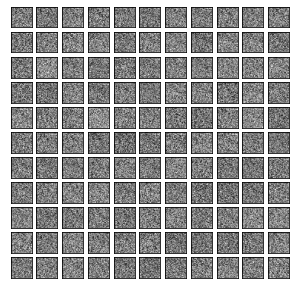

Epoch[0/200],d_loss:-0.091073,g_loss:-0.245489 D real: 0.876929,D fake: 0.538050
Epoch[0/200],d_loss:-0.308022,g_loss:-0.042256 D real: 0.900550,D fake: 0.084794


  0%|          | 1/200 [00:23<1:16:28, 23.06s/it]

Epoch[1/200],d_loss:-0.020419,g_loss:-0.322123 D real: 0.840184,D fake: 0.766543
Epoch[1/200],d_loss:-0.015424,g_loss:-0.327437 D real: 0.845968,D fake: 0.784284


  1%|          | 2/200 [00:40<1:10:47, 21.45s/it]

Epoch[2/200],d_loss:-0.092966,g_loss:-0.153777 D real: 0.599645,D fake: 0.318451
Epoch[2/200],d_loss:-0.221038,g_loss:-0.071690 D real: 0.731586,D fake: 0.144509


  2%|▏         | 3/200 [00:59<1:07:27, 20.55s/it]

Epoch[3/200],d_loss:-0.187197,g_loss:-0.081365 D real: 0.657233,D fake: 0.164557
Epoch[3/200],d_loss:-0.000004,g_loss:-0.380626 D real: 0.999193,D fake: 0.999185


  2%|▏         | 4/200 [01:16<1:03:58, 19.59s/it]

Epoch[4/200],d_loss:-0.000012,g_loss:-0.380673 D real: 0.999472,D fake: 0.999412
Epoch[4/200],d_loss:-0.000020,g_loss:-0.380664 D real: 0.999457,D fake: 0.999367


  2%|▎         | 5/200 [01:34<1:02:17, 19.17s/it]

Epoch[5/200],d_loss:-0.000039,g_loss:-0.380673 D real: 0.999505,D fake: 0.999409
Epoch[5/200],d_loss:-0.000053,g_loss:-0.380642 D real: 0.999520,D fake: 0.999263


  3%|▎         | 6/200 [01:52<1:00:48, 18.81s/it]

Epoch[6/200],d_loss:-0.000059,g_loss:-0.380610 D real: 0.999385,D fake: 0.999109
Epoch[6/200],d_loss:-0.000102,g_loss:-0.380568 D real: 0.999308,D fake: 0.998911


  4%|▎         | 7/200 [02:11<1:00:31, 18.81s/it]

Epoch[7/200],d_loss:-0.000164,g_loss:-0.380335 D real: 0.998624,D fake: 0.997803
Epoch[7/200],d_loss:-0.004283,g_loss:-0.369452 D real: 0.971361,D fake: 0.948102


  4%|▍         | 8/200 [02:29<59:26, 18.57s/it]  

Epoch[8/200],d_loss:-0.000048,g_loss:-0.380626 D real: 0.999410,D fake: 0.999187
Epoch[8/200],d_loss:-0.000091,g_loss:-0.380540 D real: 0.999317,D fake: 0.998778


  4%|▍         | 9/200 [02:47<58:55, 18.51s/it]

Epoch[9/200],d_loss:-0.001183,g_loss:-0.378640 D real: 0.995477,D fake: 0.989810
Epoch[9/200],d_loss:0.000005,g_loss:-0.380792 D real: 0.999957,D fake: 0.999978


  5%|▌         | 10/200 [03:05<57:51, 18.27s/it]

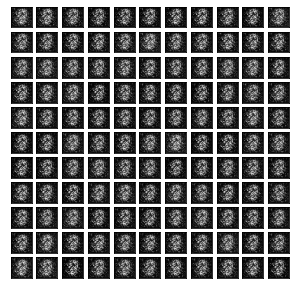

Epoch[10/200],d_loss:0.000001,g_loss:-0.380793 D real: 0.999972,D fake: 0.999979
Epoch[10/200],d_loss:0.000001,g_loss:-0.380793 D real: 0.999972,D fake: 0.999980


  6%|▌         | 11/200 [03:26<1:00:25, 19.18s/it]

Epoch[11/200],d_loss:0.000002,g_loss:-0.380793 D real: 0.999970,D fake: 0.999981
Epoch[11/200],d_loss:0.000004,g_loss:-0.380793 D real: 0.999961,D fake: 0.999981


  6%|▌         | 12/200 [03:44<58:57, 18.82s/it]  

Epoch[12/200],d_loss:0.000002,g_loss:-0.380793 D real: 0.999974,D fake: 0.999982
Epoch[12/200],d_loss:0.000003,g_loss:-0.380794 D real: 0.999966,D fake: 0.999984


  6%|▋         | 13/200 [04:02<57:25, 18.43s/it]

Epoch[13/200],d_loss:0.000001,g_loss:-0.380793 D real: 0.999979,D fake: 0.999982
Epoch[13/200],d_loss:0.000001,g_loss:-0.380794 D real: 0.999979,D fake: 0.999984


  7%|▋         | 14/200 [04:19<56:09, 18.12s/it]

Epoch[14/200],d_loss:0.000002,g_loss:-0.380794 D real: 0.999975,D fake: 0.999984
Epoch[14/200],d_loss:0.000001,g_loss:-0.380794 D real: 0.999980,D fake: 0.999984


  8%|▊         | 15/200 [04:37<55:30, 18.00s/it]

Epoch[15/200],d_loss:0.000001,g_loss:-0.380794 D real: 0.999981,D fake: 0.999985
Epoch[15/200],d_loss:0.000001,g_loss:-0.380794 D real: 0.999982,D fake: 0.999985


  8%|▊         | 16/200 [04:55<55:06, 17.97s/it]

Epoch[16/200],d_loss:0.000000,g_loss:-0.380794 D real: 0.999985,D fake: 0.999987
Epoch[16/200],d_loss:-0.000000,g_loss:-0.380795 D real: 0.999987,D fake: 0.999988


  8%|▊         | 17/200 [05:14<55:49, 18.30s/it]

Epoch[17/200],d_loss:0.000001,g_loss:-0.380794 D real: 0.999983,D fake: 0.999988
Epoch[17/200],d_loss:0.000001,g_loss:-0.380794 D real: 0.999984,D fake: 0.999986


  9%|▉         | 18/200 [05:33<55:43, 18.37s/it]

Epoch[18/200],d_loss:0.000000,g_loss:-0.380795 D real: 0.999988,D fake: 0.999989
Epoch[18/200],d_loss:-0.000001,g_loss:-0.380795 D real: 0.999990,D fake: 0.999989


 10%|▉         | 19/200 [05:50<54:37, 18.11s/it]

Epoch[19/200],d_loss:0.000000,g_loss:-0.380795 D real: 0.999989,D fake: 0.999989
Epoch[19/200],d_loss:-0.000000,g_loss:-0.380795 D real: 0.999990,D fake: 0.999988


 10%|█         | 20/200 [06:07<53:37, 17.87s/it]

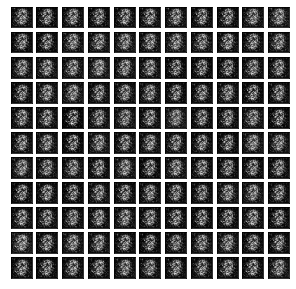

Epoch[20/200],d_loss:-0.000000,g_loss:-0.380795 D real: 0.999989,D fake: 0.999988
Epoch[20/200],d_loss:-0.000000,g_loss:-0.380795 D real: 0.999991,D fake: 0.999990


 10%|█         | 21/200 [06:30<57:15, 19.19s/it]

Epoch[21/200],d_loss:-0.000000,g_loss:-0.380795 D real: 0.999989,D fake: 0.999988
Epoch[21/200],d_loss:-0.000001,g_loss:-0.380795 D real: 0.999993,D fake: 0.999989


 11%|█         | 22/200 [06:47<55:29, 18.70s/it]

Epoch[22/200],d_loss:-0.000000,g_loss:-0.380795 D real: 0.999990,D fake: 0.999988
Epoch[22/200],d_loss:-0.000001,g_loss:-0.380794 D real: 0.999993,D fake: 0.999987


 12%|█▏        | 23/200 [07:06<54:51, 18.60s/it]

Epoch[23/200],d_loss:-0.000001,g_loss:-0.380794 D real: 0.999990,D fake: 0.999985
Epoch[23/200],d_loss:-0.000001,g_loss:-0.380794 D real: 0.999989,D fake: 0.999984


 12%|█▏        | 24/200 [07:23<53:56, 18.39s/it]

Epoch[24/200],d_loss:-0.000002,g_loss:-0.380792 D real: 0.999988,D fake: 0.999978
Epoch[24/200],d_loss:-0.000002,g_loss:-0.380791 D real: 0.999983,D fake: 0.999971


 12%|█▎        | 25/200 [07:42<53:45, 18.43s/it]

Epoch[25/200],d_loss:-0.000006,g_loss:-0.380785 D real: 0.999971,D fake: 0.999940
Epoch[25/200],d_loss:-0.000022,g_loss:-0.380722 D real: 0.999747,D fake: 0.999640


 13%|█▎        | 26/200 [08:00<53:17, 18.38s/it]

Epoch[26/200],d_loss:-0.371588,g_loss:-0.005259 D real: 0.986728,D fake: 0.010554
Epoch[26/200],d_loss:-0.225136,g_loss:-0.143516 D real: 0.909320,D fake: 0.341351


 14%|█▎        | 27/200 [08:19<52:57, 18.37s/it]

Epoch[27/200],d_loss:-0.375862,g_loss:-0.003242 D real: 0.991105,D fake: 0.006488
Epoch[27/200],d_loss:-0.318391,g_loss:-0.025587 D real: 0.880804,D fake: 0.051740


 14%|█▍        | 28/200 [08:36<52:05, 18.17s/it]

Epoch[28/200],d_loss:-0.264679,g_loss:-0.047881 D real: 0.783590,D fake: 0.096930
Epoch[28/200],d_loss:-0.348027,g_loss:-0.014468 D real: 0.942678,D fake: 0.028991


 14%|█▍        | 29/200 [08:54<51:02, 17.91s/it]

Epoch[29/200],d_loss:0.000041,g_loss:-0.380725 D real: 0.999480,D fake: 0.999656
Epoch[29/200],d_loss:0.000037,g_loss:-0.380751 D real: 0.999607,D fake: 0.999780


 15%|█▌        | 30/200 [09:13<51:47, 18.28s/it]

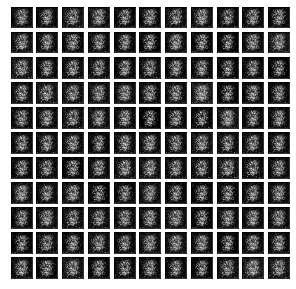

Epoch[30/200],d_loss:0.000013,g_loss:-0.380760 D real: 0.999766,D fake: 0.999821
Epoch[30/200],d_loss:0.000009,g_loss:-0.380769 D real: 0.999822,D fake: 0.999867


 16%|█▌        | 31/200 [09:36<55:47, 19.81s/it]

Epoch[31/200],d_loss:-0.000002,g_loss:-0.380771 D real: 0.999901,D fake: 0.999874
Epoch[31/200],d_loss:0.000001,g_loss:-0.380774 D real: 0.999878,D fake: 0.999890


 16%|█▌        | 32/200 [09:54<53:46, 19.21s/it]

Epoch[32/200],d_loss:0.000003,g_loss:-0.380778 D real: 0.999901,D fake: 0.999908
Epoch[32/200],d_loss:0.000002,g_loss:-0.380778 D real: 0.999905,D fake: 0.999909


 16%|█▋        | 33/200 [10:13<52:59, 19.04s/it]

Epoch[33/200],d_loss:-0.000001,g_loss:-0.380780 D real: 0.999922,D fake: 0.999917
Epoch[33/200],d_loss:-0.000001,g_loss:-0.380782 D real: 0.999925,D fake: 0.999928


 17%|█▋        | 34/200 [10:30<51:30, 18.62s/it]

Epoch[34/200],d_loss:0.000003,g_loss:-0.380781 D real: 0.999917,D fake: 0.999925
Epoch[34/200],d_loss:0.000004,g_loss:-0.380782 D real: 0.999913,D fake: 0.999930


 18%|█▊        | 35/200 [10:48<50:19, 18.30s/it]

Epoch[35/200],d_loss:-0.000003,g_loss:-0.380783 D real: 0.999945,D fake: 0.999933
Epoch[35/200],d_loss:-0.000000,g_loss:-0.380784 D real: 0.999937,D fake: 0.999936


 18%|█▊        | 36/200 [11:06<49:45, 18.21s/it]

Epoch[36/200],d_loss:-0.000001,g_loss:-0.380782 D real: 0.999942,D fake: 0.999929
Epoch[36/200],d_loss:-0.000000,g_loss:-0.380783 D real: 0.999936,D fake: 0.999935


 18%|█▊        | 37/200 [11:24<49:29, 18.22s/it]

Epoch[37/200],d_loss:-0.000002,g_loss:-0.380782 D real: 0.999932,D fake: 0.999929
Epoch[37/200],d_loss:-0.000004,g_loss:-0.380781 D real: 0.999942,D fake: 0.999923


 19%|█▉        | 38/200 [11:41<48:30, 17.97s/it]

Epoch[38/200],d_loss:-0.000003,g_loss:-0.380780 D real: 0.999926,D fake: 0.999919
Epoch[38/200],d_loss:-0.000002,g_loss:-0.380773 D real: 0.999912,D fake: 0.999886


 20%|█▉        | 39/200 [12:00<48:47, 18.18s/it]

Epoch[39/200],d_loss:-0.000015,g_loss:-0.380757 D real: 0.999878,D fake: 0.999811
Epoch[39/200],d_loss:-0.000067,g_loss:-0.380594 D real: 0.999290,D fake: 0.999032


 20%|██        | 40/200 [12:18<48:26, 18.16s/it]

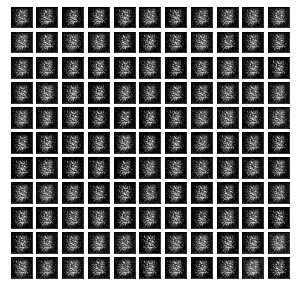

Epoch[40/200],d_loss:0.000347,g_loss:-0.380740 D real: 0.997955,D fake: 0.999730
Epoch[40/200],d_loss:0.000018,g_loss:-0.380793 D real: 0.999893,D fake: 0.999980


 20%|██        | 41/200 [12:42<52:47, 19.92s/it]

Epoch[41/200],d_loss:0.000009,g_loss:-0.380795 D real: 0.999947,D fake: 0.999990
Epoch[41/200],d_loss:0.000006,g_loss:-0.380795 D real: 0.999962,D fake: 0.999990


 21%|██        | 42/200 [13:01<51:25, 19.53s/it]

Epoch[42/200],d_loss:0.000003,g_loss:-0.380796 D real: 0.999978,D fake: 0.999993
Epoch[42/200],d_loss:0.000005,g_loss:-0.380796 D real: 0.999972,D fake: 0.999993


 22%|██▏       | 43/200 [13:18<49:17, 18.84s/it]

Epoch[43/200],d_loss:0.000003,g_loss:-0.380796 D real: 0.999980,D fake: 0.999995
Epoch[43/200],d_loss:0.000002,g_loss:-0.380796 D real: 0.999987,D fake: 0.999996


 22%|██▏       | 44/200 [13:37<48:54, 18.81s/it]

Epoch[44/200],d_loss:0.000004,g_loss:-0.380796 D real: 0.999979,D fake: 0.999996
Epoch[44/200],d_loss:0.000002,g_loss:-0.380796 D real: 0.999987,D fake: 0.999996


 22%|██▎       | 45/200 [13:55<48:28, 18.77s/it]

Epoch[45/200],d_loss:0.000001,g_loss:-0.380796 D real: 0.999993,D fake: 0.999997
Epoch[45/200],d_loss:0.000001,g_loss:-0.380796 D real: 0.999989,D fake: 0.999997


 23%|██▎       | 46/200 [14:12<46:48, 18.24s/it]

Epoch[46/200],d_loss:0.000001,g_loss:-0.380796 D real: 0.999993,D fake: 0.999997
Epoch[46/200],d_loss:0.000001,g_loss:-0.380796 D real: 0.999994,D fake: 0.999997


 24%|██▎       | 47/200 [14:31<46:46, 18.35s/it]

Epoch[47/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999995,D fake: 0.999998
Epoch[47/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999996,D fake: 0.999998


 24%|██▍       | 48/200 [14:49<45:52, 18.11s/it]

Epoch[48/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999996,D fake: 0.999998
Epoch[48/200],d_loss:0.000001,g_loss:-0.380797 D real: 0.999992,D fake: 0.999999


 24%|██▍       | 49/200 [15:06<44:55, 17.85s/it]

Epoch[49/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999996,D fake: 0.999998
Epoch[49/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999996,D fake: 0.999998


 25%|██▌       | 50/200 [15:24<44:45, 17.90s/it]

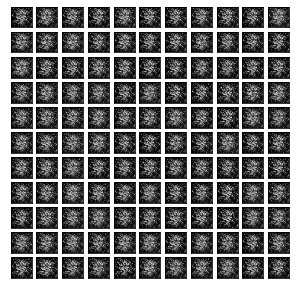

Epoch[50/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999997,D fake: 0.999999
Epoch[50/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999997,D fake: 0.999999


 26%|██▌       | 51/200 [15:47<48:01, 19.34s/it]

Epoch[51/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999997,D fake: 0.999998
Epoch[51/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 0.999998


 26%|██▌       | 52/200 [16:05<46:44, 18.95s/it]

Epoch[52/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 0.999999
Epoch[52/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 0.999999


 26%|██▋       | 53/200 [16:23<45:44, 18.67s/it]

Epoch[53/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999
Epoch[53/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 0.999999


 27%|██▋       | 54/200 [16:40<44:32, 18.30s/it]

Epoch[54/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999
Epoch[54/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999


 28%|██▊       | 55/200 [16:58<43:51, 18.15s/it]

Epoch[55/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 0.999999
Epoch[55/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999


 28%|██▊       | 56/200 [17:16<43:13, 18.01s/it]

Epoch[56/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999
Epoch[56/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999


 28%|██▊       | 57/200 [17:34<43:08, 18.10s/it]

Epoch[57/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 0.999999
Epoch[57/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999


 29%|██▉       | 58/200 [17:52<43:12, 18.25s/it]

Epoch[58/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999
Epoch[58/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999


 30%|██▉       | 59/200 [18:11<43:17, 18.42s/it]

Epoch[59/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999
Epoch[59/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999998


 30%|███       | 60/200 [18:30<43:06, 18.47s/it]

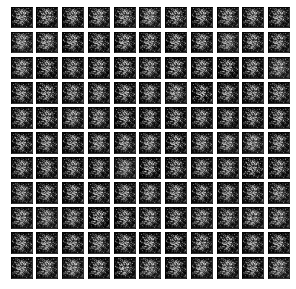

Epoch[60/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999998
Epoch[60/200],d_loss:-0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999998


 30%|███       | 61/200 [18:52<45:33, 19.67s/it]

Epoch[61/200],d_loss:-0.000000,g_loss:-0.380796 D real: 0.999999,D fake: 0.999997
Epoch[61/200],d_loss:-0.000001,g_loss:-0.380795 D real: 0.999997,D fake: 0.999991


 31%|███       | 62/200 [19:11<44:17, 19.26s/it]

Epoch[62/200],d_loss:-0.380730,g_loss:-0.000061 D real: 0.999968,D fake: 0.000122
Epoch[62/200],d_loss:-0.380752,g_loss:-0.000038 D real: 0.999941,D fake: 0.000075


 32%|███▏      | 63/200 [19:29<43:17, 18.96s/it]

Epoch[63/200],d_loss:-0.380751,g_loss:-0.000027 D real: 0.999931,D fake: 0.000054
Epoch[63/200],d_loss:-0.380762,g_loss:-0.000028 D real: 0.999949,D fake: 0.000057


 32%|███▏      | 64/200 [19:46<41:49, 18.45s/it]

Epoch[64/200],d_loss:-0.380755,g_loss:-0.000027 D real: 0.999925,D fake: 0.000053
Epoch[64/200],d_loss:-0.380758,g_loss:-0.000026 D real: 0.999936,D fake: 0.000052


 32%|███▎      | 65/200 [20:04<41:03, 18.25s/it]

Epoch[65/200],d_loss:-0.380703,g_loss:-0.000027 D real: 0.999784,D fake: 0.000054
Epoch[65/200],d_loss:-0.380633,g_loss:-0.000076 D real: 0.999771,D fake: 0.000152


 33%|███▎      | 66/200 [20:22<40:49, 18.28s/it]

Epoch[66/200],d_loss:-0.344549,g_loss:-0.020613 D real: 0.967126,D fake: 0.042094
Epoch[66/200],d_loss:-0.379516,g_loss:-0.000389 D real: 0.998151,D fake: 0.000778


 34%|███▎      | 67/200 [20:41<40:51, 18.43s/it]

Epoch[67/200],d_loss:-0.338881,g_loss:-0.027333 D real: 0.967786,D fake: 0.062424
Epoch[67/200],d_loss:-0.378780,g_loss:-0.001027 D real: 0.995688,D fake: 0.002054


 34%|███▍      | 68/200 [21:00<40:34, 18.44s/it]

Epoch[68/200],d_loss:-0.379714,g_loss:-0.000617 D real: 0.997877,D fake: 0.001234
Epoch[68/200],d_loss:-0.379864,g_loss:-0.000436 D real: 0.998237,D fake: 0.000871


 34%|███▍      | 69/200 [21:17<39:53, 18.27s/it]

Epoch[69/200],d_loss:-0.379667,g_loss:-0.000465 D real: 0.997606,D fake: 0.000931
Epoch[69/200],d_loss:-0.372929,g_loss:-0.005220 D real: 0.992021,D fake: 0.010660


 35%|███▌      | 70/200 [21:36<39:34, 18.27s/it]

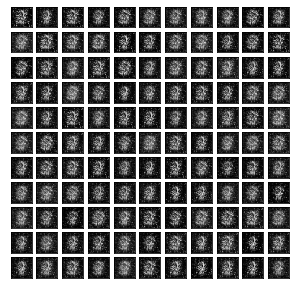

Epoch[70/200],d_loss:-0.180708,g_loss:-0.172294 D real: 0.857962,D fake: 0.417500
Epoch[70/200],d_loss:-0.368363,g_loss:-0.006226 D real: 0.975857,D fake: 0.012497


 36%|███▌      | 71/200 [21:58<42:07, 19.59s/it]

Epoch[71/200],d_loss:-0.291136,g_loss:-0.026735 D real: 0.840635,D fake: 0.053666
Epoch[71/200],d_loss:-0.208663,g_loss:-0.111647 D real: 0.846151,D fake: 0.260924


 36%|███▌      | 72/200 [22:16<40:26, 18.96s/it]

Epoch[72/200],d_loss:-0.305718,g_loss:-0.028282 D real: 0.873415,D fake: 0.057533
Epoch[72/200],d_loss:-0.323509,g_loss:-0.022344 D real: 0.897091,D fake: 0.046127


 36%|███▋      | 73/200 [22:35<39:58, 18.89s/it]

Epoch[73/200],d_loss:-0.056601,g_loss:-0.249660 D real: 0.780909,D fake: 0.602065
Epoch[73/200],d_loss:-0.321837,g_loss:-0.030611 D real: 0.903828,D fake: 0.062593


 37%|███▋      | 74/200 [22:53<39:10, 18.65s/it]

Epoch[74/200],d_loss:-0.206141,g_loss:-0.104985 D real: 0.801146,D fake: 0.244751
Epoch[74/200],d_loss:-0.214887,g_loss:-0.094332 D real: 0.765660,D fake: 0.200752


 38%|███▊      | 75/200 [23:12<39:00, 18.72s/it]

Epoch[75/200],d_loss:-0.111647,g_loss:-0.202060 D real: 0.762299,D fake: 0.477863
Epoch[75/200],d_loss:-0.299260,g_loss:-0.046398 D real: 0.851193,D fake: 0.098312


 38%|███▊      | 76/200 [23:30<38:20, 18.55s/it]

Epoch[76/200],d_loss:-0.334631,g_loss:-0.028568 D real: 0.921824,D fake: 0.059272
Epoch[76/200],d_loss:-0.047279,g_loss:-0.236474 D real: 0.728195,D fake: 0.559097


 38%|███▊      | 77/200 [23:48<38:03, 18.56s/it]

Epoch[77/200],d_loss:-0.000025,g_loss:-0.380658 D real: 0.999149,D fake: 0.999339
Epoch[77/200],d_loss:0.000098,g_loss:-0.380625 D real: 0.998977,D fake: 0.999182


 39%|███▉      | 78/200 [24:06<37:21, 18.38s/it]

Epoch[78/200],d_loss:-0.000033,g_loss:-0.380658 D real: 0.999424,D fake: 0.999341
Epoch[78/200],d_loss:0.000128,g_loss:-0.380661 D real: 0.998958,D fake: 0.999354


 40%|███▉      | 79/200 [24:25<37:01, 18.36s/it]

Epoch[79/200],d_loss:0.000038,g_loss:-0.380620 D real: 0.999382,D fake: 0.999162
Epoch[79/200],d_loss:-0.000090,g_loss:-0.380642 D real: 0.998933,D fake: 0.999263


 40%|████      | 80/200 [24:42<35:54, 17.95s/it]

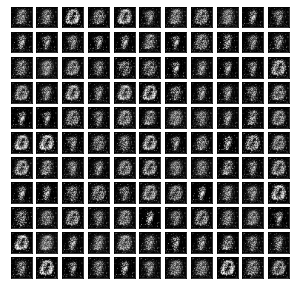

Epoch[80/200],d_loss:-0.363178,g_loss:-0.005212 D real: 0.975938,D fake: 0.010435
Epoch[80/200],d_loss:0.000009,g_loss:-0.380794 D real: 0.999926,D fake: 0.999988


 40%|████      | 81/200 [25:04<38:09, 19.24s/it]

Epoch[81/200],d_loss:0.000008,g_loss:-0.380795 D real: 0.999950,D fake: 0.999990
Epoch[81/200],d_loss:0.000004,g_loss:-0.380796 D real: 0.999972,D fake: 0.999993


 41%|████      | 82/200 [25:22<37:02, 18.83s/it]

Epoch[82/200],d_loss:0.000005,g_loss:-0.380796 D real: 0.999972,D fake: 0.999994
Epoch[82/200],d_loss:0.000003,g_loss:-0.380796 D real: 0.999981,D fake: 0.999995


 42%|████▏     | 83/200 [25:40<36:23, 18.66s/it]

Epoch[83/200],d_loss:0.000004,g_loss:-0.380796 D real: 0.999977,D fake: 0.999994
Epoch[83/200],d_loss:0.000003,g_loss:-0.380796 D real: 0.999983,D fake: 0.999997


 42%|████▏     | 84/200 [25:58<35:43, 18.48s/it]

Epoch[84/200],d_loss:0.000002,g_loss:-0.380796 D real: 0.999990,D fake: 0.999997
Epoch[84/200],d_loss:0.000005,g_loss:-0.380796 D real: 0.999976,D fake: 0.999997


 42%|████▎     | 85/200 [26:17<35:37, 18.59s/it]

Epoch[85/200],d_loss:0.000001,g_loss:-0.380797 D real: 0.999993,D fake: 0.999997
Epoch[85/200],d_loss:0.000002,g_loss:-0.380797 D real: 0.999989,D fake: 0.999998


 43%|████▎     | 86/200 [26:34<34:43, 18.28s/it]

Epoch[86/200],d_loss:0.000002,g_loss:-0.380797 D real: 0.999991,D fake: 0.999998
Epoch[86/200],d_loss:0.000001,g_loss:-0.380797 D real: 0.999995,D fake: 0.999999


 44%|████▎     | 87/200 [26:52<34:19, 18.23s/it]

Epoch[87/200],d_loss:0.000001,g_loss:-0.380797 D real: 0.999996,D fake: 0.999999
Epoch[87/200],d_loss:0.000001,g_loss:-0.380797 D real: 0.999995,D fake: 0.999998


 44%|████▍     | 88/200 [27:10<33:49, 18.12s/it]

Epoch[88/200],d_loss:0.000003,g_loss:-0.380797 D real: 0.999985,D fake: 0.999999
Epoch[88/200],d_loss:0.000001,g_loss:-0.380797 D real: 0.999996,D fake: 0.999999


 44%|████▍     | 89/200 [27:28<33:16, 17.98s/it]

Epoch[89/200],d_loss:0.000001,g_loss:-0.380797 D real: 0.999996,D fake: 0.999999
Epoch[89/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999997,D fake: 0.999999


 45%|████▌     | 90/200 [27:46<33:07, 18.07s/it]

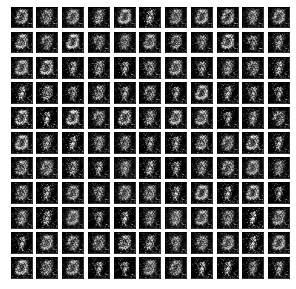

Epoch[90/200],d_loss:0.000001,g_loss:-0.380797 D real: 0.999996,D fake: 0.999999
Epoch[90/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999997,D fake: 0.999999


 46%|████▌     | 91/200 [28:09<35:09, 19.35s/it]

Epoch[91/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 1.000000
Epoch[91/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 0.999999


 46%|████▌     | 92/200 [28:27<34:02, 18.92s/it]

Epoch[92/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 1.000000
Epoch[92/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 1.000000


 46%|████▋     | 93/200 [28:45<33:29, 18.78s/it]

Epoch[93/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000
Epoch[93/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999998,D fake: 1.000000


 47%|████▋     | 94/200 [29:04<33:08, 18.76s/it]

Epoch[94/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000
Epoch[94/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000


 48%|████▊     | 95/200 [29:22<32:22, 18.50s/it]

Epoch[95/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000
Epoch[95/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000


 48%|████▊     | 96/200 [29:39<31:43, 18.30s/it]

Epoch[96/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000
Epoch[96/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000


 48%|████▊     | 97/200 [29:59<31:48, 18.53s/it]

Epoch[97/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000
Epoch[97/200],d_loss:0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 49%|████▉     | 98/200 [30:15<30:21, 17.86s/it]

Epoch[98/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000
Epoch[98/200],d_loss:0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 50%|████▉     | 99/200 [30:33<30:08, 17.90s/it]

Epoch[99/200],d_loss:0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[99/200],d_loss:0.000000,g_loss:-0.380797 D real: 0.999999,D fake: 1.000000


 50%|█████     | 100/200 [30:51<29:59, 17.99s/it]

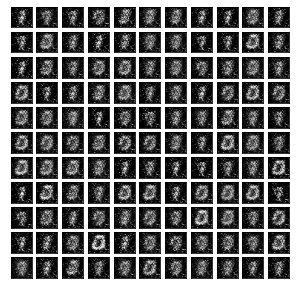

Epoch[100/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[100/200],d_loss:0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 50%|█████     | 101/200 [31:13<31:43, 19.23s/it]

Epoch[101/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[101/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 51%|█████     | 102/200 [31:31<30:35, 18.73s/it]

Epoch[102/200],d_loss:0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[102/200],d_loss:0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 52%|█████▏    | 103/200 [31:49<29:51, 18.46s/it]

Epoch[103/200],d_loss:0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[103/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 52%|█████▏    | 104/200 [32:06<29:02, 18.15s/it]

Epoch[104/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[104/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 52%|█████▎    | 105/200 [32:24<28:50, 18.21s/it]

Epoch[105/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[105/200],d_loss:0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 53%|█████▎    | 106/200 [32:43<28:32, 18.21s/it]

Epoch[106/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[106/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 54%|█████▎    | 107/200 [32:59<27:33, 17.78s/it]

Epoch[107/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[107/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 54%|█████▍    | 108/200 [33:17<27:15, 17.78s/it]

Epoch[108/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[108/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 55%|█████▍    | 109/200 [33:35<27:02, 17.83s/it]

Epoch[109/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[109/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 55%|█████▌    | 110/200 [33:54<27:07, 18.08s/it]

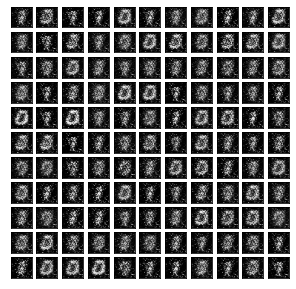

Epoch[110/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[110/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 56%|█████▌    | 111/200 [34:16<28:46, 19.40s/it]

Epoch[111/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[111/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 56%|█████▌    | 112/200 [34:34<27:50, 18.98s/it]

Epoch[112/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[112/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 56%|█████▋    | 113/200 [34:52<26:50, 18.51s/it]

Epoch[113/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[113/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 57%|█████▋    | 114/200 [35:09<26:08, 18.24s/it]

Epoch[114/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[114/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 57%|█████▊    | 115/200 [35:28<26:02, 18.38s/it]

Epoch[115/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[115/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 58%|█████▊    | 116/200 [35:45<25:21, 18.11s/it]

Epoch[116/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[116/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 58%|█████▊    | 117/200 [36:03<24:45, 17.89s/it]

Epoch[117/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[117/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 59%|█████▉    | 118/200 [36:22<24:52, 18.20s/it]

Epoch[118/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[118/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 60%|█████▉    | 119/200 [36:40<24:26, 18.11s/it]

Epoch[119/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[119/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 60%|██████    | 120/200 [36:58<24:21, 18.26s/it]

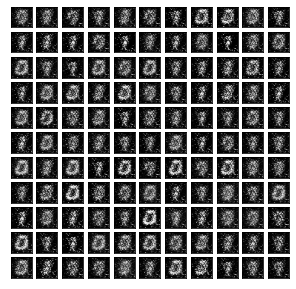

Epoch[120/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[120/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 60%|██████    | 121/200 [37:21<25:43, 19.54s/it]

Epoch[121/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[121/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 61%|██████    | 122/200 [37:39<24:57, 19.19s/it]

Epoch[122/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[122/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 62%|██████▏   | 123/200 [37:58<24:20, 18.97s/it]

Epoch[123/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[123/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 62%|██████▏   | 124/200 [38:16<23:40, 18.69s/it]

Epoch[124/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[124/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 62%|██████▎   | 125/200 [38:35<23:31, 18.82s/it]

Epoch[125/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[125/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 63%|██████▎   | 126/200 [38:53<23:05, 18.72s/it]

Epoch[126/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[126/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 64%|██████▎   | 127/200 [39:11<22:33, 18.55s/it]

Epoch[127/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[127/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 64%|██████▍   | 128/200 [39:30<22:22, 18.64s/it]

Epoch[128/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[128/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 64%|██████▍   | 129/200 [39:48<21:43, 18.36s/it]

Epoch[129/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[129/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 65%|██████▌   | 130/200 [40:06<21:22, 18.32s/it]

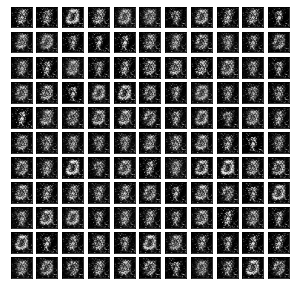

Epoch[130/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[130/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 66%|██████▌   | 131/200 [40:31<23:14, 20.21s/it]

Epoch[131/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[131/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 66%|██████▌   | 132/200 [40:49<22:14, 19.62s/it]

Epoch[132/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[132/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 66%|██████▋   | 133/200 [41:05<20:43, 18.57s/it]

Epoch[133/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[133/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 67%|██████▋   | 134/200 [41:24<20:28, 18.62s/it]

Epoch[134/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[134/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 68%|██████▊   | 135/200 [41:42<19:57, 18.42s/it]

Epoch[135/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[135/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 68%|██████▊   | 136/200 [42:01<19:45, 18.52s/it]

Epoch[136/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[136/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 68%|██████▊   | 137/200 [42:17<18:55, 18.03s/it]

Epoch[137/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[137/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 69%|██████▉   | 138/200 [42:36<18:40, 18.08s/it]

Epoch[138/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[138/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 70%|██████▉   | 139/200 [42:55<18:44, 18.43s/it]

Epoch[139/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[139/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 70%|███████   | 140/200 [43:13<18:12, 18.21s/it]

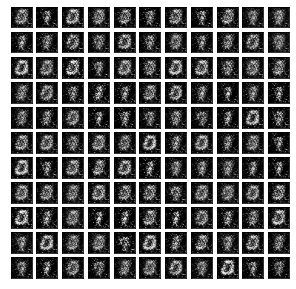

Epoch[140/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[140/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 70%|███████   | 141/200 [43:35<19:14, 19.57s/it]

Epoch[141/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[141/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 71%|███████   | 142/200 [43:52<18:05, 18.71s/it]

Epoch[142/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[142/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 72%|███████▏  | 143/200 [44:10<17:31, 18.45s/it]

Epoch[143/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[143/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 72%|███████▏  | 144/200 [44:28<17:05, 18.32s/it]

Epoch[144/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[144/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 72%|███████▎  | 145/200 [44:46<16:52, 18.41s/it]

Epoch[145/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[145/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 73%|███████▎  | 146/200 [45:05<16:35, 18.43s/it]

Epoch[146/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[146/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 74%|███████▎  | 147/200 [45:22<15:59, 18.10s/it]

Epoch[147/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[147/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 74%|███████▍  | 148/200 [45:40<15:38, 18.06s/it]

Epoch[148/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[148/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 74%|███████▍  | 149/200 [45:59<15:26, 18.16s/it]

Epoch[149/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[149/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 75%|███████▌  | 150/200 [46:16<15:01, 18.03s/it]

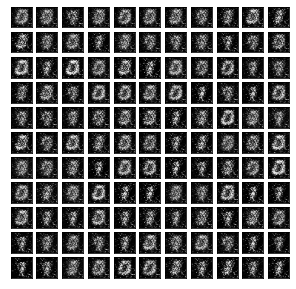

Epoch[150/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[150/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 76%|███████▌  | 151/200 [46:38<15:36, 19.12s/it]

Epoch[151/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[151/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 76%|███████▌  | 152/200 [46:56<15:03, 18.83s/it]

Epoch[152/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[152/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 76%|███████▋  | 153/200 [47:15<14:41, 18.76s/it]

Epoch[153/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[153/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 77%|███████▋  | 154/200 [47:33<14:12, 18.54s/it]

Epoch[154/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[154/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 78%|███████▊  | 155/200 [47:52<13:56, 18.60s/it]

Epoch[155/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[155/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 78%|███████▊  | 156/200 [48:10<13:40, 18.64s/it]

Epoch[156/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[156/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 78%|███████▊  | 157/200 [48:29<13:27, 18.79s/it]

Epoch[157/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[157/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 79%|███████▉  | 158/200 [48:47<12:59, 18.55s/it]

Epoch[158/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[158/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 80%|███████▉  | 159/200 [49:04<12:15, 17.95s/it]

Epoch[159/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[159/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 80%|████████  | 160/200 [49:23<12:07, 18.18s/it]

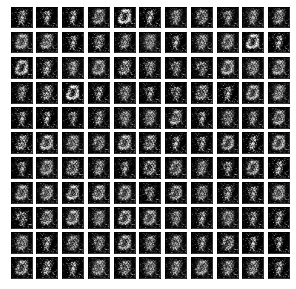

Epoch[160/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[160/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 80%|████████  | 161/200 [49:46<12:45, 19.64s/it]

Epoch[161/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[161/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 81%|████████  | 162/200 [50:04<12:08, 19.18s/it]

Epoch[162/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[162/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 82%|████████▏ | 163/200 [50:21<11:32, 18.71s/it]

Epoch[163/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[163/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 82%|████████▏ | 164/200 [50:40<11:06, 18.51s/it]

Epoch[164/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[164/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 82%|████████▎ | 165/200 [50:57<10:36, 18.18s/it]

Epoch[165/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[165/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 83%|████████▎ | 166/200 [51:15<10:13, 18.06s/it]

Epoch[166/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[166/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 84%|████████▎ | 167/200 [51:33<09:54, 18.00s/it]

Epoch[167/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[167/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 84%|████████▍ | 168/200 [51:50<09:28, 17.78s/it]

Epoch[168/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[168/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 84%|████████▍ | 169/200 [52:08<09:12, 17.83s/it]

Epoch[169/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[169/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 85%|████████▌ | 170/200 [52:26<09:01, 18.06s/it]

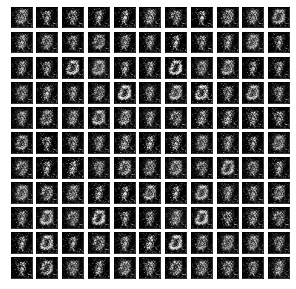

Epoch[170/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[170/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 86%|████████▌ | 171/200 [52:50<09:36, 19.87s/it]

Epoch[171/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[171/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 86%|████████▌ | 172/200 [53:09<09:03, 19.43s/it]

Epoch[172/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[172/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 86%|████████▋ | 173/200 [53:27<08:31, 18.95s/it]

Epoch[173/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[173/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 87%|████████▋ | 174/200 [53:44<07:58, 18.42s/it]

Epoch[174/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[174/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 88%|████████▊ | 175/200 [54:03<07:44, 18.60s/it]

Epoch[175/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[175/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 88%|████████▊ | 176/200 [54:20<07:16, 18.18s/it]

Epoch[176/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[176/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 88%|████████▊ | 177/200 [54:38<06:53, 18.00s/it]

Epoch[177/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[177/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 89%|████████▉ | 178/200 [54:56<06:39, 18.16s/it]

Epoch[178/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[178/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 90%|████████▉ | 179/200 [55:15<06:28, 18.48s/it]

Epoch[179/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[179/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 90%|█████████ | 180/200 [55:34<06:10, 18.51s/it]

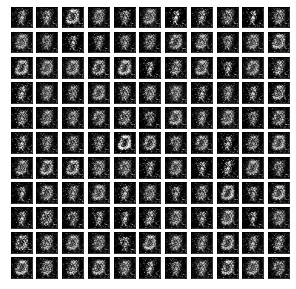

Epoch[180/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[180/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 90%|█████████ | 181/200 [55:58<06:21, 20.07s/it]

Epoch[181/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[181/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 91%|█████████ | 182/200 [56:17<05:54, 19.69s/it]

Epoch[182/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[182/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 92%|█████████▏| 183/200 [56:36<05:34, 19.66s/it]

Epoch[183/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[183/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 92%|█████████▏| 184/200 [56:54<05:03, 18.99s/it]

Epoch[184/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[184/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 92%|█████████▎| 185/200 [57:10<04:32, 18.17s/it]

Epoch[185/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[185/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 93%|█████████▎| 186/200 [57:28<04:16, 18.32s/it]

Epoch[186/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[186/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 94%|█████████▎| 187/200 [57:47<03:58, 18.33s/it]

Epoch[187/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[187/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 94%|█████████▍| 188/200 [58:06<03:43, 18.65s/it]

Epoch[188/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[188/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 94%|█████████▍| 189/200 [58:24<03:22, 18.38s/it]

Epoch[189/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[189/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 95%|█████████▌| 190/200 [58:42<03:03, 18.35s/it]

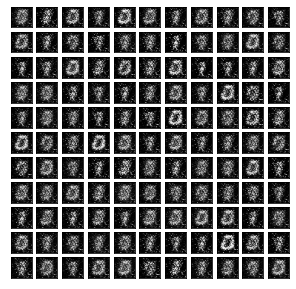

Epoch[190/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[190/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 96%|█████████▌| 191/200 [59:06<02:59, 19.99s/it]

Epoch[191/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[191/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 96%|█████████▌| 192/200 [59:24<02:34, 19.29s/it]

Epoch[192/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[192/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 96%|█████████▋| 193/200 [59:41<02:10, 18.65s/it]

Epoch[193/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[193/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 97%|█████████▋| 194/200 [59:59<01:51, 18.55s/it]

Epoch[194/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[194/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 98%|█████████▊| 195/200 [1:00:17<01:31, 18.36s/it]

Epoch[195/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[195/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 98%|█████████▊| 196/200 [1:00:34<01:12, 18.02s/it]

Epoch[196/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[196/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 98%|█████████▊| 197/200 [1:00:52<00:53, 17.87s/it]

Epoch[197/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[197/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


 99%|█████████▉| 198/200 [1:01:10<00:35, 17.81s/it]

Epoch[198/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[198/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


100%|█████████▉| 199/200 [1:01:27<00:17, 17.56s/it]

Epoch[199/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000
Epoch[199/200],d_loss:-0.000000,g_loss:-0.380797 D real: 1.000000,D fake: 1.000000


100%|██████████| 200/200 [1:01:43<00:00, 18.52s/it]


In [10]:
for epoch in tqdm(range(num_epoch)):
    # ========================= Generation and Visualization ====================
    if epoch % 10 == 0:
        G.eval()
        z = torch.randn(batch_size, z_dimension).to(device)
        img = G(z)
        plt.close()
        grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(img[k].data.view(28,28).cpu().numpy(), cmap='gray')
            k += 1
        plt.show()
    
    # =========================== Training Code ==================================
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images
        # =============================== LABELS =================================
        real_label = torch.ones(num_img).view(-1, 1).to(device) # Label of real images is 1
        fake_label = torch.zeros(num_img).view(-1, 1).to(device) # label of real images is 0
        
        # ========================= D: Forward and Loss ==========================
        
        real_out = D(real_img)
        # real_out is DX_score      
        
        z = torch.randn(num_img, z_dimension).to(device)
        fake_img = G(z)
        fake_out = D(fake_img)
        # fake_out is DG_score
        
        d_loss = criterion.D_loss(real_out, fake_out)
        
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        
        # =============== G ========================
        # To fool the Discriminator, we want G's fake output can get 'real' pridection
        z = torch.randn(num_img, z_dimension).to(device)
        fake_img = G(z)
        fake_out = D(fake_img)
        g_loss = criterion.G_loss(fake_out)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # ============= Visualization ===============
        if (i+1)%200 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean()  #打印的是真实图片的损失均值
            ))
        
    #if epoch == 0:
    #    real_images = to_gray_img(real_img.cpu().data)
    #    save_image(real_images, '../img/real_images.png')
 
    #fake_images = to_gray_img(fake_img.cpu().data)
    #save_image(fake_images, '../img/fake_images-{}.png'.format(epoch+1))

- Jason_shannon is ok
- total 发散了
- forward KL 1e-6 ok
- Person


# Debug 专区

In [11]:
print(real_out.size())

torch.Size([96, 1])


In [12]:
torch.save(G.state_dict(),'./generator.pth')
torch.save(D.state_dict(),'./discriminator.pth')